In [137]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# 데이터 전처리

### 데이터 불러오기

In [138]:
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [139]:
ratings.user_id.nunique()

6040

### 선호도 기준 정하기

In [140]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


### 암묵적 평가로 지표 변경

In [141]:
# rating 컬럼의 이름을 count로 바꿉니다.
ratings.rename(columns={'rating':'count'}, inplace=True)
ratings

,user_id,movie_id,count,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


### 사용하지 않는 Col 제거

In [142]:
ratings.drop('timestamp', axis=1, inplace=True)
ratings.head()

,user_id,movie_id,count
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


### 영화 ID 전처리

In [143]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
print(movies.shape)
movies.head()

(3883, 3)


,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### movie ID 재정렬

In [144]:
print("Max of Movie ID : ", movies['movie_id'].max())
print("Number of Movie ID : ", movies['movie_id'].nunique())

movies['new_id'] = list(range(movies.shape[0]))
movies.head()

Max of Movie ID :  3952
Number of Movie ID :  3883


,movie_id,title,genre,new_id
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


### 영화 제목과 ID 병합

In [145]:
idx_to_title, title_to_idx = {}, {}
for i, data in movies[['new_id', 'title']].iterrows():
    idx_to_title[data.new_id] = data.title
    title_to_idx[data.title] = data.new_id

print(movies.shape)
movies.head()

(3883, 4)


,movie_id,title,genre,new_id
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [146]:
ratings = pd.merge(ratings, movies[['movie_id', 'title', 'new_id']], how='left', on=['movie_id'])
ratings.head()

,user_id,movie_id,count,title,new_id
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),1176
1,1,661,3,James and the Giant Peach (1996),655
2,1,914,3,My Fair Lady (1964),902
3,1,3408,4,Erin Brockovich (2000),3339
4,1,2355,5,"Bug's Life, A (1998)",2286


# 데이터 탐색

### 유니크한 유저, 영화 수

In [147]:
print('The Number of Users :', ratings.user_id.nunique())
print('The Number of Movies :', ratings.new_id.nunique())

The Number of Users : 6039
The Number of Movies : 3628


### 인기있는 top30 영화

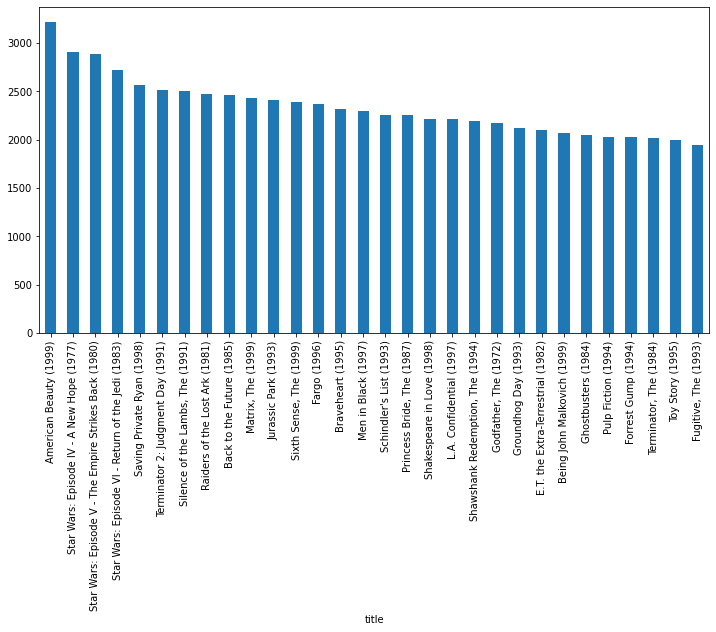

In [148]:
ratings.groupby('title')['user_id'].count().sort_values(ascending=False).head(30).plot(kind='bar', figsize=(12,6))
plt.show()

# 선호하는 영화 5가지 추가

In [149]:
print(max(ratings['user_id']))
movies.sort_values(by='title', key=lambda x: x.str[-5:-1], ascending=False).head(5)

6040


,movie_id,title,genre,new_id
3882,3952,"Contender, The (2000)",Drama|Thriller,3882
3528,3597,Whipped (2000),Comedy,3528
3577,3646,Big Momma's House (2000),Comedy,3577
3170,3239,Isn't She Great? (2000),Comedy,3170
3555,3624,Shanghai Noon (2000),Action,3555


In [150]:
my_favorite = ['Metro (1997)' , 'Gun Shy (2000)' ,'Running Free (2000)' ,'Fall (1997)' ,'Prince Valiant (1997)']

# 'zimin'이라는 user_id가 위 아티스트의 노래를 30회씩 들었다고 가정하겠습니다.
my_movie = pd.DataFrame({'user_id': ['6041']*5, 
                         'title': my_favorite, 
                         'count':[5]*5,
                         'new_id': [title_to_idx[t] for t in my_favorite]})

if not ratings.isin({'user_id':['6041']})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면
    ratings = ratings.append(my_movie)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

ratings.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,movie_id,count,title,new_id
836473,6040,1090.0,3,Platoon (1986),1074
836474,6040,1094.0,5,"Crying Game, The (1992)",1078
836475,6040,562.0,5,Welcome to the Dollhouse (1995),558
836476,6040,1096.0,4,Sophie's Choice (1982),1080
836477,6040,1097.0,4,E.T. the Extra-Terrestrial (1982),1081
0,6041,NaN,5,Metro (1997),1408
1,6041,NaN,5,Gun Shy (2000),3207
2,6041,NaN,5,Running Free (2000),3578
3,6041,NaN,5,Fall (1997),1534
4,6041,NaN,5,Prince Valiant (1997),1780


# CSR Matrix 만들기

In [153]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

ratings.reset_index(drop=True)
ratings = ratings.astype({'new_id' : 'int64', 'user_id' : 'int64'} )
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836483 entries, 0 to 4
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   836483 non-null  int64  
 1   movie_id  836478 non-null  float64
 2   count     836483 non-null  int64  
 3   title     836483 non-null  object 
 4   new_id    836483 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 38.3+ MB


In [163]:
csr_data = csr_matrix((ratings['count'], (ratings.user_id-1, ratings.new_id)))
csr_data

<6041x3883 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Row format>

# 학습

### Config 설정 및 모델 생성

In [166]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

csr_data_transpose = csr_data.T
csr_data_transpose

# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

### 학습 진행

In [167]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

# 학습 결과

### 결과 확인

In [176]:
my_id = ratings.user_id.max() - 1
my_favorite = ['Metro (1997)' , 'Gun Shy (2000)' ,'Running Free (2000)' ,'Fall (1997)' ,'Prince Valiant (1997)']
print('Result of User Factor : ', als_model.user_factors[my_id].shape)
print('Result of Item Factor : ', als_model.item_factors[title_to_idx[my_favorite[0]]].shape)

Result of User Factor :  (100,)
Result of Item Factor :  (100,)


# 추천하기

### 비슷한 영화

In [181]:
similar_movie = als_model.similar_items(title_to_idx[my_favorite[0]], N=10)
for idx, score in similar_movie:
    title = idx_to_title[idx]
    print(title, score)

Metro (1997) 1.0
Sudden Death (1995) 0.8477172
Money Train (1995) 0.83577806
Maximum Risk (1996) 0.83471054
Fire Down Below (1997) 0.83224696
Striking Distance (1993) 0.82755065
Glimmer Man, The (1996) 0.8219217
Knock Off (1998) 0.8196521
Turbulence (1997) 0.8194547
Fled (1996) 0.8190853


### 유저에게 영화 추천하기

In [182]:
my_id = ratings.user_id.max() - 1
movie_recommended = als_model.recommend(my_id, csr_data, N=20, filter_already_liked_items=True)
[idx_to_title[i[0]] for i in movie_recommended]

['Whole Nine Yards, The (2000)',
 "Schindler's List (1993)",
 "One Flew Over the Cuckoo's Nest (1975)",
 'Keeping the Faith (2000)',
 'Dogma (1999)',
 'Romeo Must Die (2000)',
 'Fisher King, The (1991)',
 'Jackal, The (1997)',
 'Insider, The (1999)',
 'Mr. Nice Guy (1997)',
 'Supercop (1992)',
 'Gods Must Be Crazy, The (1980)',
 'Operation Condor (Feiying gaiwak) (1990)',
 'Last Man Standing (1996)',
 'Bowfinger (1999)',
 'Last Action Hero (1993)',
 'Glimmer Man, The (1996)',
 'High Fidelity (2000)',
 'Under Siege 2: Dark Territory (1995)',
 'Star Trek: Insurrection (1998)']